In [10]:
import time
import os
import math
import datetime
import random
import json
import collections
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import cascaded_union

NOT_AVAILABLE_MSG = "No Available Trip in The Given Service Day"



In [2]:
# trips_df = pd.read_csv("../../../data/mmt_gtfs/trips.csv")
# routes_df = pd.read_csv("../../../data/mmt_gtfs/routes.csv")
# stops_df = pd.read_csv("../../../data/bus_route_stop_info/stops.csv")
# stops_df = stops_df[stops_df["Route"] != "None"]  # filter stops that are not currently in service
# stop_times_df = pd.read_csv("../../../data/mmt_gtfs/stop_times.csv")
# calender_df = pd.read_csv("../../../data/mmt/calendar.csv")
city = gpd.read_file("../../../data/plot/background/madison-shp")
water = gpd.read_file("../../../data/plot/background/water-shp")
street = gpd.read_file("../../../data/plot/background/streets-shp")
# zones = gpd.read_file("../../../data/plot/background/zoning_districts-shp")
# zones = zones.dropna(subset=["ZONING_COD"])  # filter districts without ZONING_COD data
wards = gpd.read_file("../../../data/population/wards-shp")
pop = pd.read_csv("../../../data/population/population.csv")
wards = wards[wards["WARD"].isin(pop["Ward"])]
ward_areas = gpd.read_file("../../../data/plot/background/ward_area-shp")

In [3]:
# borrowed from chang's busSim
from busSim import BusSim
from graph import Graph
trips_df = pd.read_csv("../../../data/mmt/trips.csv")
routes_df = pd.read_csv("../../../data/mmt/routes.csv")
stop_times_df = pd.read_csv("../../../data/mmt/stop_times.csv")
calender_df = pd.read_csv("../../../data/mmt/calendar.csv")
stops_df = pd.read_csv("../../../data/mmt/stops.csv")


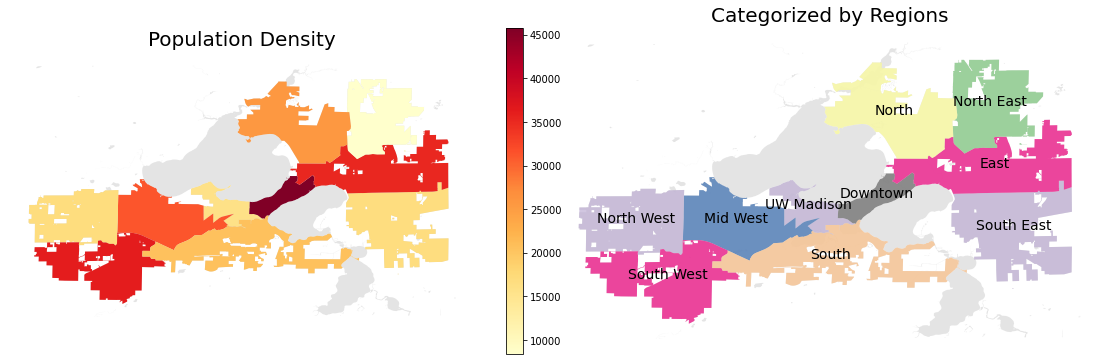

In [18]:
uw_madison = [
    55, 58, 59, 60, 61, 62, 63, 66, 67
]
mid_west = [
    64, 65, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89
]
north_west = [
    88, 109, 108, 110, 120, 107, 140, 127, 111, 122, 143, 138, 124,
    104, 141, 117
]
south_west = [
    90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
    105, 106, 119, 137, 125, 114, 115, 116, 121, 144,
]
south = [
    68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 113, 139
]
downtown = [
    41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57
]
south_east = [
    1, 2, 3, 4, 5, 6, 7, 13, 14, 15, 132, 133, 134
]
east = [
    39, 40, 8, 9, 10, 11, 12, 16, 17, 128, 129, 130, 131,
    18, 19, 20, 22, 136, 29
]
north_east = [
    21, 23, 24, 25, 26, 126, 142, 145
]
north = [
    27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 112, 118, 135
]

regions = [uw_madison, mid_west, north_west, south_west, south, downtown,
           south_east, east, north_east, north]
w = []
r = []
p = []
g = []
for ward in sorted(list(set(wards["WARD"]))):

    # polygon
    if len(wards[wards["WARD"] == ward]) > 1:
        polygons = list(wards[wards["WARD"] == ward]["geometry"])
        boundary = gpd.GeoSeries(cascaded_union(polygons))
        g.append(boundary.iloc[0])
    else:
        g.append(wards[wards["WARD"] == ward].iloc[0, -1])

    # ward
    w.append(ward)

    # region
    if ward in uw_madison:
        r.append("UW Madison")
    elif ward in mid_west:
        r.append("Mid West")
    elif ward in north_west:
        r.append("North West")
    elif ward in south_west:
        r.append("South West")
    elif ward in south:
        r.append("South")
    elif ward in downtown:
        r.append("Downtown")
    elif ward in south_east:
        r.append("South East")
    elif ward in east:
        r.append("East")
    elif ward in north_east:
        r.append("North East")
    else:
        r.append("North")

    # population
    p.append(pop[pop["Ward"] == ward]["total"].sum())


temp_wards = pd.DataFrame(
    {
        "ward":w,
        "region":r,
        "population":p,
        "geometry":g
    })
temp_wards = temp_wards.set_geometry("geometry")
temp_wards.head()

regions = ["UW Madison", "Mid West", "North West", "South West", "South",
           "Downtown", "South East", "East", "North East", "North"]

population = []
polys = []
for region in regions:
    temp =  temp_wards[temp_wards["region"] == region]

    population.append(temp["population"].sum())

    polygons = list(temp["geometry"])
    boundary = gpd.GeoSeries(cascaded_union(polygons))
    polys.append(boundary.iloc[0])

reg_df = pd.DataFrame({
    "region":regions,
    "population":population,
    "geometry":polys
})
reg_df = reg_df.set_geometry("geometry")

############## plot #######################################################
fig, (ax0, ax1) = plt.subplots(figsize=(20, 6), ncols=2)
plt.subplots_adjust(wspace=-0.1)

ax0.set_axis_off()
ax1.set_axis_off()

city.plot(ax=ax0, color="0.85", alpha=0.7, zorder=1)
water.plot(ax=ax0, color="0.85", alpha=0.7, zorder=1)

city.plot(ax=ax1, color="0.85", alpha=0.7, zorder=1)
water.plot(ax=ax1, color="0.85", alpha=0.7, zorder=1)

reg_df.plot(ax=ax0, column="population", legend=True, cmap='YlOrRd', zorder=2)
reg_df.plot(ax=ax1, column="population", cmap='Accent', zorder=2, alpha=0.7)

for region in regions:
    center = reg_df[reg_df["region"] == region]["geometry"].centroid
    ax1.text(center.x, center.y, region, ha="center", color="k", size=14)

ax0.set_title("Population Density", size=20)
ax1.set_title("Categorized by Regions", size=20)

plt.savefig("final/andy3.png", dpi=400, bbox_inches="tight")

##########################################

In [5]:
reg_df.head()

,region,population,geometry
0,UW Madison,15872.937162,"POLYGON ((-89.40097 43.06766, -89.39921 43.067..."
1,Mid West,31278.867953,"POLYGON ((-89.44324 43.05115, -89.44336 43.051..."
2,North West,16972.245322,"MULTIPOLYGON (((-89.56015 43.04568, -89.56352 ..."
3,South West,36245.634873,"POLYGON ((-89.50040 43.00126, -89.50047 43.001..."
4,South,20580.988733,"MULTIPOLYGON (((-89.35804 43.03897, -89.35822 ..."


In [6]:
total_stops = []
for idx1, row1 in reg_df.iterrows():
    stops = []
    poly = row1["geometry"]
    for idx2, row2 in stops_df.iterrows():
        lat = row2["stop_lat"]
        lon = row2["stop_lon"]
        # print(lon, lat)


        if poly.contains(Point(lon, lat)):
            stops.append(row2["stop_id"])
    total_stops.append(stops)

In [7]:
reg_df["stop_ids"] = total_stops
reg_df.head(2)

,region,population,geometry,stop_ids
0,UW Madison,15872.937162,"POLYGON ((-89.40097 43.06766, -89.39921 43.067...","[5, 47, 52, 56, 60, 61, 100, 104, 113, 133, 16..."
1,Mid West,31278.867953,"POLYGON ((-89.44324 43.05115, -89.44336 43.051...","[2437, 6000, 6100, 2100, 2101, 2105, 2109, 211..."


In [13]:
dts = []
for hr in range(24):
    if hr > 4:
        dts.append("{}:00:00".format(hr))
        if hr == 23:
            break
        dts.append("{}:30:00".format(hr))

dfs = pd.DataFrame(index=dts, columns=regions)
avg_areas = {}

DATA_PATH = "../../../data"
DAY = "monday"
# START_TIME = "12:00:00"
ELAPSE_TIME = "00:20:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 10
for dt in dts[:5]:

    areas = []
    START_TIME = dt

    busSim = BusSim(DATA_PATH, DAY, START_TIME, ELAPSE_TIME,
                    AVG_WALKING_SPEED, MAX_WALKING_MIN)

    reg = 0
    found = 0
    not_found = 0
    for idx, row in reg_df[:1].iterrows():
        reg = row["region"]
        temp = stops_df[stops_df["stop_id"].isin(row["stop_ids"])]
        print("len(temp) = ", len(temp))
        for idx1, row1 in temp.iterrows():
            lat = row1["stop_lat"]
            lon = row1["stop_lon"]
            id = row1["stop_id"]
            try:
                gdf = busSim.get_gdf(start_point=(lon, lat))
                areas.append(busSim.get_area(gdf))
                found += 1
            except:
                not_found += 1
                continue
    print("dt = {}, found = {}, not_found = {}".format(dt, found, not_found))
    avg_areas[reg] = sum(areas) / (len(areas) + 1)

avg_areas

len(temp) =  138
dt = 5:00:00, found = 138, not_found = 0
len(temp) =  138
dt = 5:30:00, found = 137, not_found = 1
len(temp) =  138
dt = 6:00:00, found = 138, not_found = 0
len(temp) =  138
dt = 6:30:00, found = 138, not_found = 0
len(temp) =  138
dt = 7:00:00, found = 138, not_found = 0


{'UW Madison': 0.0}

In [10]:
stops_df.head(2)

,Unnamed: 0,OBJECTID,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,agency_id,location_t,...,Light,Reaitime,PK_MD_WE,jurisdicti,relative_p,cardinal_d,primary_st,address_ra,cross_loca,geometry
10,10,12802,4100,4100,South Transfer Point,This stop (#4100) is on the pedestrian island ...,43.038895,-89.394824,MMT,0,...,1,1,111,MTSM,5,NaN,South Transfer Point,2430,S Park,POINT (-89.39482329790644 43.03889733390121)
12,12,12804,5100,5100,North Transfer Point,This stop (#5100) is on the pedestrian island ...,43.113253,-89.358540,MMT,0,...,1,1,111,MTSM,5,NaN,North Transfer Point,1213,Huxley,POINT (-89.35853910475025 43.11325541503273)


In [ ]:
serv_types = {
    "wkd": ["93_WKD", "93_WKD:L#6", "93_WKD:L=6", "93_WKD:R",
            "93_WKD:S", "93_WKD:S#6", "93_WKD:S=6"],
    "sat": ["93_SAT", "93_SAT:L", "93_SAT:R", "93_SAT:S"],
    "sun": ["93_SUN", "93_SUN:L", "93_SUN:R", "93_SUN:S"],
    "hol": ["93_D24", "93_D31", "93_HOL", "93_HOL:R"],
    "mwk": ["93_MWK", "93_MWK:R"]}

def generate_random(ward_file, pop_file, num_points=None, perc_pop=None):
    """
    Generate random points from the given ward_file (wards-shp) and pop_file (populaiton.csv).
    Note:
        One of num_points and perc_pop parameters should be None,
        or both of them are None.
        1. When both of them are None: 253,030 points will be generated.
        2. num_points specified:       generate points >= 144 * num_points.
        3. perc_pop   specified:       generate points >= 253,030 * (perc / 100)
    Args:
        ward_file:  shapely file with geometry data to generate points within each shape
        pop_file:   population density file categorized by wards
        num_points: number of points generated at each ward
        perc_pop:   for example, perc_pop=50 is 50 percent of the population
                    in that ward will be generated. perc_pop should be > 0, and < 100
    Returns:
        A dictionary of points (vals) categorized into 5 zoning districts (keys).
    """
    points_by_wards = {}

    for idx, row in ward_file.iterrows():

        # ward number
        ward = row["WARD"]

        if num_points:
            pop = num_points
        elif perc_pop:
            pop = math.ceil(pop_file[pop_file["Ward"].isin([ward])]["total"].iloc[0] * perc_pop * 0.01)
        else:
            raise ValueError("num_points and perc_pop cannot both be None")

        # skip the ward where population is 0
        # and avoid generating points in the same ward
        if pop == 0:
            continue
        else:
            points_by_wards[ward] = []
            shp_df = ward_file[ward_file["WARD"].isin([ward])]
            idx = 0
            if len(shp_df) > 1:
                idx = np.random.randint(low=0, high=len(shp_df))
            poly = shp_df.iloc[idx, -1]
            while len(points_by_wards[ward]) < pop:

                minx, miny, maxx, maxy = poly.bounds
                pnt = Point(random.uniform(minx, maxx),
                            random.uniform(miny, maxy))
                if poly.contains(pnt):
                    points_by_wards[ward].append(pnt)

    return collections.OrderedDict(sorted(points_by_wards.items()))

# source: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def find_near_stops(points, stops_df, threshold=400):
    """
    Find the nearest bus stops for each point in the points parameter.

    Args:
        points:    a list of shapely Point objects
        stops_df:
        threshold: find number of bus stops within the distance threshold (in meters)
                   by default is 400 meters (or 1/4 miles). e.g. number of bus stops
                   within 400 meters from one generated point.
    Returns:
        a DataFrame of columns: districts, stop_id, stop_lat, stop_lon,
                                pt_lon, pt_lat, distance (in meters),
                                num_available_stops, num_available_routes, ids_dist
    """
    ids =        []  # store the stop id of the nearest bus stop
    dists =      []  # store the shortest distance to the nearest bus stop
    stop_lons =  []  # longitude of the stop id
    stop_lats =  []  # latitude of the stop id
    pt_lons =    []  # longitude of the generated pt
    pt_lats =    []  # latitude of the generated pt
    wards =  []  # district name where the pt is generated
    num_stops =  []  # number of available bus stops within the distance threshold (None if the nearest one > threshold)
    routes =     []  # available routes within the distance threshold (None if the nearest one > threshold)
    num_routes = []  # number of avaialable routes within the distance threshold (None if the nearest one > threshold)
    ids_dist =   []  # list of tuples of (stop_ids, distances) to the bus stop (None if the nearest one > threshold)

    for key, pts in points.items():
        for pt in pts:
            xs = [pt.x] * len(stops_df)
            ys = [pt.y] * len(stops_df)

             # element wise operation to calculate distances
            kms = haversine_np(xs, ys, stops_df["stop_lon"], stops_df["stop_lat"])

            idx = kms.idxmin()  # index of the smallest value
            stop_id = stops_df.loc[idx, "stop_id"]
            lon = stops_df.loc[idx, "stop_lon"]
            lat = stops_df.loc[idx, "stop_lat"]
            dist = round(kms.loc[idx] * 1000, 2)  # convert km to meters

            ids.append(stop_id)
            stop_lons.append(lon)
            stop_lats.append(lat)
            pt_lons.append(pt.x)
            pt_lats.append(pt.y)
            dists.append(dist)
            wards.append(key)

            # calculate number of available bus stops and routes
            # within the threshold distance

            ####################################################################
            ##################    Optimization approach    #####################
            ####################################################################
            #
            # ms = kms * 1000
            # fitered_ms = ms[ms <= threshold]
            # sorted_filtered_ms = fitered_ms.sort_values(ascending=True)
            # num_stops_cnt = len(sorted_filtered_ms)
            # num_routes_cnt = stops_df[stops_df.index.isin([sorted_filtered_ms.index])]["Route"].str.split(",")
            # ids_dist_tuple = list(pd.DataFrame(
            #                             {
            #                                 'stop_id': stops_df[stops_df["stop_id"].isin([sorted_filtered_ms.index])]["stop_id"],
            #                                 'dist': np.round(sorted_filtered_ms.values, 2)
            #                             }).to_records(index=False))
            ####################################################################
            ####################################################################
            ####################################################################

            sorted_km = kms.sort_values(ascending=True)
            num_stops_cnt  = 0
            num_routes_cnt = []
            ids_dist_tuple = []
            for idx, val in sorted_km.items():
                dist = round(val * 1000, 2)
                if dist <= threshold:
                    num_stops_cnt += 1
                    ids_dist_tuple.append((stops_df.loc[idx, "stop_id"], dist))
                    num_routes_cnt.extend(stops_df.loc[idx, "Route"].split(", "))
                else:
                    break

            num_stops.append(num_stops_cnt)
            routes.append(sorted(map(int, list(set(num_routes_cnt)))))
            num_routes.append(len(list(set(num_routes_cnt))))
            ids_dist.append(ids_dist_tuple)

    stops = pd.DataFrame({
        "wards": wards,
        "pt_lon": pt_lons,
        "pt_lat": pt_lats,
        "stop_id (nearest)": ids,
        "stop_lon (nearest)": stop_lons,
        "stop_lat (nearest)": stop_lats,
        "distance (nearest, in meters)": dists,
        "num_available_stops (within {}m)".format(threshold): num_stops,
        "num_available_routes (within {}m)".format(threshold): num_routes,
        "available_routes (within {}m)".format(threshold): routes,
        "ids_dist": ids_dist
    })
    return stops

def to_time_format(sec):
    hour = int(sec.seconds / 3600)
    minute = int((sec.seconds - 3600 * hour) / 60)
    seconds = int(sec.seconds - 3600 * hour - 60 * minute)
    return ":".join(map(str, [hour, minute, seconds]))

def minute_wait(stops, t, serv, trips_df, stop_times_df):
    """
    Find the soonest coming bus and calculate the expected waiting times,
    given the time and service type

    Args:
        stops: stops dataframe returned by the find_near_stops columns
        t:     time, datatime object
        serv:  service type (wkd, sat, sun, hol, mwk)
    Returns:

    """
    # filtered trips by service type
    trips_by_serv = trips_df[trips_df["service_id"].isin(serv_types[serv])]

    min_waits = []     # list of minimum waiting time
    chosen_trip_ids = []  # list of minimum waiting time trip_id
    chosen_stop_ids = []  # list of chosen stop_id


    for idx, row in stops.iterrows():

        # if there are many bus stops within the threshold distance,
        # we want to find the soonest coming bus from all near bus stops
        # else use the nearest if no bus stops nearby
        stop_ids = []
        if len(row["ids_dist"]) == 0:
            stop_ids = [row["stop_id (nearest)"]]
        else:
            stop_ids = [tup[0] for tup in row["ids_dist"]]


        # filter stop_id by service type
        matched_stops = stop_times_df[stop_times_df["stop_id"].isin(stop_ids)]
        filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]
        matched = matched_stops[matched_stops["trip_id"].isin(filtered_trips["trip_id"])]

        # find waiting time for the soonest coming route and trip_id of that route
        schedules = pd.to_timedelta(matched["arrival_time"])


        if len(schedules) != 0:
            times = pd.Series([datetime.timedelta(hours=t.hour,
                                                  minutes=t.minute,
                                                  seconds=t.second)] * len(schedules), index=schedules.index)
            diff = schedules - times
            sorted_diff_sec = diff.sort_values().dt.total_seconds()
            diff_sec = sorted_diff_sec[sorted_diff_sec > 0]


            if len(diff_sec) == 0:
                #############################################################################
                ##########   there're routes that only run at a certain time   ##############
                ##########   e.g. in the morning                               ##############
                #############################################################################
                min_waits.append(None)
                chosen_trip_ids.append(None)
                chosen_stop_ids.append(None)
            else:
                min_waits.append(diff_sec.iloc[0] / 60)
                chosen_trip_ids.append(matched.loc[diff_sec.index[0]]["trip_id"])
                chosen_stop_ids.append(matched.loc[diff_sec.index[0]]["stop_id"])
        else:
            min_waits.append(None)
            chosen_trip_ids.append(None)
            chosen_stop_ids.append(None)

    stops["minutes_wait"] = min_waits
    stops["trip_id (chosen)"] = chosen_trip_ids
    stops["stop_id (chosen)"] = chosen_stop_ids

    # find the route that's coming by trip_id
    route_coming = []
    for idx, row in stops.iterrows():
        trip_id = row["trip_id (chosen)"]
        try:
            if np.isnan(trip_id):
                route_coming.append(NOT_AVAILABLE_MSG)
            else:
                route_coming.append(trips_df[trips_df["trip_id"].isin([trip_id])]["route_short_name"].iloc[0])
        except TypeError:
                route_coming.append(NOT_AVAILABLE_MSG)
    stops["coming_route"] = route_coming

    return stops


def get_service_type(serv):
    """convert service_type for the use of plot title"""
    if serv == "wkd":
        return "Weekday"
    if serv == "sat" or "sun":
        return "Weekend"
    if serv == "hol":
        return "Holiday"
    else:
        return "Modified_Week"

def get_full_time(t):
    """convert time object for the use of plot title"""
    return " at " + str(t.hour) + ":" + str(t.minute) + ":" + str(t.second)

def generate_sim(t, serv,
                 wards_df, pops_df, stops_df, stop_times_df, trips_df,
                 num_points=None, perc_pop=None, coords=None, threshold=400, geo_plot=False):
    """
    Randomly generates points in Madison and calculates nearest stop_id, lon/lat, distance
    from each point, and calculates the number of available stops/routes within the given
    threshold distance, and estimates the minimum waiting time from all avaialable stops within the
    given threshold distance.

    Args:
        t:
        serv:
        wards_df:
        pops_df:
        stops_df:
        stop_times_df:
        trips_df:
        num_points: see docstring of generate_randome() method
        perc_pop:   see docstring of generate_randome() method
        coords:     a dictionary with key = wards, val = list of points
                    if not given, randomly generate points using generate_random() method
        threshold:
        geo_plot:
    Return:
        A dataframe of simulated data and a randomly generated points for the use of
        generating a set of simulations of different times and service types.
    """
    points = 0
    if coords == None:
        points = generate_random(wards_df, pops_df, num_points, perc_pop)
    else:
        points = coords
    cnt = sum([len(val) for key, val in points.items()])
    stops = find_near_stops(points, stops_df, threshold)
    stops = minute_wait(stops, t, serv, trips_df, stop_times_df)
    return points, stops

t = datetime.time(12, 00, 00)
serv = "wkd"
start = time.time()
points, wkd = generate_sim(t, serv, wards, pop,
                           stops_df, stop_times_df, trips_df,
                           perc_pop=0.1, geo_plot=True)
# points, wkd = generate_sim(t, serv, wards, pop,
#                            stops_df, stop_times_df, trips_df,
#                            num_points=2, geo_plot=True)

len(wkd)


In [ ]:
# normal, route removal
# ward 1
# -------------------------------------------
#      | sim 1 | sim 2 | sim 3 | sim 4 | ...
# ---- | ----- | ----- | ----- | ----- | ...
# 5:00 |
# 5:30 |
# 6:00 |
# 6:30 |
# 7:00 |
# ...

# ward 2
# -------------------------------------------
#      | sim 1 | sim 2 | sim 3 | sim 4 | ...
# ---- | ----- | ----- | ----- | ----- | ...
# 5:00 |
# 5:30 |
# 6:00 |
# 6:30 |
# 7:00 |
# ...

dfs = []
start = time.time()
dts = []
for hr in range(24):
    if hr > 4:
        dts.append("{}:00:00".format(hr))
        if hr == 23:
            break
        dts.append("{}:30:00".format(hr))

SIM = 1
DAY = "monday"
START_TIME = "8:00:00"
ELAPSE_TIME = "00:20:00"
avg_walking_speed = 1.5  # m/sec



# processing time required for walking to bus stop
time_temp1 = START_TIME.split(":")
time_temp2 = ELAPSE_TIME.split(":")
start_time = datetime.timedelta(hours=int(time_temp1[0]),
                                minutes=int(time_temp1[1]),
                                seconds=int(time_temp1[2]))
elapse_time = datetime.timedelta(hours=int(time_temp2[0]),
                                 minutes=int(time_temp2[1]),
                                 seconds=int(time_temp2[2]))

area_df = pd.DataFrame(index=list(pts.keys()))

for s in range(SIM):
    print("sim ", s)
    area = []
    for idx1, row1 in df.iterrows():
        ward = row1["wards"]
        # print("ward = ", ward)
        # compute average
        area_total = 0
        pt_cnt = 0

        df2 = df[df["wards"].isin([ward])]

        for idx1, row2 in df2.iterrows():

            # if there are stops nearby

            # suppose they all go the nearest bus stop
            walking_to_stop = row2["distance (nearest, in meters)"] / avg_walking_speed

            # adding time for walking to bus stop to start_time and elapse_time
            new_start_time = start_time + datetime.timedelta(seconds=walking_to_stop)
            new_elapse_time = elapse_time - datetime.timedelta(seconds=walking_to_stop)

            area_temp = 0
            if new_elapse_time.days < 0 or new_elapse_time.seconds <= 0:
                area_temp = avg_walking_speed * elapse_time.seconds
                # print("stops too far")
            else:
                START_TIME = to_time_format(new_start_time)
                ELAPSE_TIME = to_time_format(new_elapse_time)
                # print(START_TIME, ELAPSE_TIME)

                busSim = BusSim(DAY, START_TIME, ELAPSE_TIME)
                gdf = busSim.get_gdf(start_point=(row2["stop_lat (nearest)"],
                                                  row2["stop_lon (nearest)"]),
                                     stops_df=trips_df,
                                     trips_df=stops_df,
                                     stopTimes_df=stop_times_df,
                                     calendar_df=calender_df,
                                     lakes=water)
                area_temp = busSim.get_area(gdf)
                if area_temp == 0:
                    # print("no service at given stop")
                    area_temp = avg_walking_speed * elapse_time.seconds

            # print(area_temp)

            pt_cnt += 1
            area_total += area_temp

        area.append(round((area_total / pt_cnt), 2))

    area_df["sim_{}".format(s + 1)] = area

end = time.time()
print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

area_df

In [ ]:
# service type
serv_types = {
    "wkd": ["93_WKD", "93_WKD:L#6", "93_WKD:L=6", "93_WKD:R",
            "93_WKD:S", "93_WKD:S#6", "93_WKD:S=6"],
    "sat": ["93_SAT", "93_SAT:L", "93_SAT:R", "93_SAT:S"],
    "sun": ["93_SUN", "93_SUN:L", "93_SUN:R", "93_SUN:S"],
    "hol": ["93_D24", "93_D31", "93_HOL", "93_HOL:R"],
    "mwk": ["93_MWK", "93_MWK:R"]}


def generate_random(ward_file, pop_file, num_points=None, perc_pop=None):
    """
    Generate random points from the given ward_file (wards-shp) and pop_file (populaiton.csv).
    Note:
        One of num_points and perc_pop parameters should be None,
        or both of them are None.
        1. When both of them are None: 253,030 points will be generated.
        2. num_points specified:       generate points >= 144 * num_points.
        3. perc_pop   specified:       generate points >= 253,030 * (perc / 100)
    Args:
        ward_file:  shapely file with geometry data to generate points within each shape
        pop_file:   population density file categorized by wards
        num_points: number of points generated at each ward
        perc_pop:   for example, perc_pop=50 is 50 percent of the population
                    in that ward will be generated. perc_pop should be > 0, and < 100
    Returns:
        A dictionary of points (vals) categorized into 5 zoning districts (keys).
    """
    points_by_wards = {}

    for idx, row in ward_file.iterrows():

        # ward number
        ward = row["WARD"]

        if num_points != None:
            pop = num_points
        elif perc_pop != None:
            pop = pop_file[pop_file["Ward"].isin([ward])]["total"].iloc[0] * perc_pop * 0.01
        else:
            pop  = pop_file[pop_file["Ward"].isin([ward])]["total"].iloc[0]

        # skip the ward where population is 0
        # and avoid generating points in the same ward
        if pop == 0 or ward in points_by_wards:
            continue
        else:
            points_by_wards[ward] = []
            shp_df = ward_file[ward_file["WARD"].isin([ward])]

            ############################################################
            ############################################################
            # example:
            # ward 1 is split into 3 polygons in wards.shp-file
            # suppose num_points is 10, we ceil(10 / 3) = 4
            # so there will be 12 points generated in ward 1,
            # each polygon will contain 4 points
            ############################################################
            ############################################################

            # there'll be cases when a ward has more than one polygons
            pop_for_each = math.ceil(pop / len(shp_df))
            for i in range(len(shp_df)):
                poly = shp_df.iloc[i, -1]
                while len(points_by_wards[ward]) < pop_for_each * (i + 1):
                    minx, miny, maxx, maxy = poly.bounds
                    pnt = Point(random.uniform(minx, maxx),
                                random.uniform(miny, maxy))
                    if poly.contains(pnt):
                        points_by_wards[ward].append(pnt)

    return points_by_wards

def plot_random(random_points, ax, **kwargs):
    """
    Generate a geo-plot using points generated by the generate_random() method.

    Args:
         random_points: points returned by generate_random() method
         ax:            ax to plot the geo map
         **kwargs:      setting of the geo map
    Returns:
        A dictionary of points (vals) categorized into area of wards (keys).
    """

    handles = []
    points = random_points  # points_by_zone
    for key, pts in points.items():
        x = []
        y = []
        for pt in pts:
            x.append(float(pt.x))
            y.append(float(pt.y))
        plt.scatter(x, y, c="k", **kwargs)

    return points

# source: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def find_near_stops(points, stops_df, threshold=400):
    """
    Find the nearest bus stops for each point in the points parameter.

    Args:
        points:    a list of shapely Point objects
        stops_df:
        threshold: find number of bus stops within the distance threshold (in meters)
                   by default is 400 meters (or 1/4 miles). e.g. number of bus stops
                   within 400 meters from one generated point.
    Returns:
        a DataFrame of columns: districts, stop_id, stop_lat, stop_lon,
                                pt_lon, pt_lat, distance (in meters),
                                num_available_stops, num_available_routes, ids_dist
    """
    ids =        []  # store the stop id of the nearest bus stop
    dists =      []  # store the shortest distance to the nearest bus stop
    stop_lons =  []  # longitude of the stop id
    stop_lats =  []  # latitude of the stop id
    pt_lons =    []  # longitude of the generated pt
    pt_lats =    []  # latitude of the generated pt
    wards =  []  # district name where the pt is generated
    num_stops =  []  # number of available bus stops within the distance threshold (None if the nearest one > threshold)
    routes =     []  # available routes within the distance threshold (None if the nearest one > threshold)
    num_routes = []  # number of avaialable routes within the distance threshold (None if the nearest one > threshold)
    ids_dist =   []  # list of tuples of (stop_ids, distances) to the bus stop (None if the nearest one > threshold)

    for key, pts in points.items():
        for pt in pts:
            xs = [pt.x] * len(stops_df)
            ys = [pt.y] * len(stops_df)

             # element wise operation to calculate distances
            kms = haversine_np(xs, ys, stops_df["stop_lon"], stops_df["stop_lat"])

            idx = kms.idxmin()  # index of the smallest value
            stop_id = stops_df.loc[idx, "stop_id"]
            lon = stops_df.loc[idx, "stop_lon"]
            lat = stops_df.loc[idx, "stop_lat"]
            dist = round(kms.loc[idx] * 1000, 2)  # convert km to meters

            ids.append(stop_id)
            stop_lons.append(lon)
            stop_lats.append(lat)
            pt_lons.append(pt.x)
            pt_lats.append(pt.y)
            dists.append(dist)
            wards.append(key)

            # calculate number of available bus stops and routes
            # within the threshold distance

            ####################################################################
            ##################    Optimization approach    #####################
            ####################################################################
            #
            # ms = kms * 1000
            # fitered_ms = ms[ms <= threshold]
            # sorted_filtered_ms = fitered_ms.sort_values(ascending=True)
            # num_stops_cnt = len(sorted_filtered_ms)
            # num_routes_cnt = stops_df[stops_df.index.isin([sorted_filtered_ms.index])]["Route"].str.split(",")
            # ids_dist_tuple = list(pd.DataFrame(
            #                             {
            #                                 'stop_id': stops_df[stops_df["stop_id"].isin([sorted_filtered_ms.index])]["stop_id"],
            #                                 'dist': np.round(sorted_filtered_ms.values, 2)
            #                             }).to_records(index=False))
            ####################################################################
            ####################################################################
            ####################################################################

            sorted_km = kms.sort_values(ascending=True)
            num_stops_cnt  = 0
            num_routes_cnt = []
            ids_dist_tuple = []
            for idx, val in sorted_km.items():
                dist = round(val * 1000, 2)
                if dist <= threshold:
                    num_stops_cnt += 1
                    ids_dist_tuple.append((stops_df.loc[idx, "stop_id"], dist))
                    num_routes_cnt.extend(stops_df.loc[idx, "Route"].split(", "))
                else:
                    break

            num_stops.append(num_stops_cnt)
            routes.append(sorted(map(int, list(set(num_routes_cnt)))))
            num_routes.append(len(list(set(num_routes_cnt))))
            ids_dist.append(ids_dist_tuple)

    stops = pd.DataFrame({
        "wards": wards,
        "pt_lon": pt_lons,
        "pt_lat": pt_lats,
        "stop_id (nearest)": ids,
        "stop_lon (nearest)": stop_lons,
        "stop_lat (nearest)": stop_lats,
        "distance (nearest, in meters)": dists,
        "num_available_stops (within {}m)".format(threshold): num_stops,
        "num_available_routes (within {}m)".format(threshold): num_routes,
        "available_routes (within {}m)".format(threshold): routes,
        "ids_dist": ids_dist
    })
    return stops

def connect_to_stops(ax, stops):
    """
    Draw a line from randomly generated points to nearest bus stops that are in service.

    Args:
        ax: ax to draw lines
        stops: stops dataframe returned by find_near_stop() method
    Returns:
        None
    """
    linestrings = []
    for idx, row in stops.iterrows():
        ls = LineString([(row["pt_lon"], row["pt_lat"]),
                         (row["stop_lon (nearest)"], row["stop_lat (nearest)"])])
        linestrings.append(ls)

    df = pd.DataFrame({"geometry":linestrings})
    df.set_geometry("geometry").plot(ax=ax, color="k", linestyle="--", alpha=0.5)


def minute_wait(stops, t, serv, trips_df, stop_times_df):
    """
    Find the soonest coming bus and calculate the expected waiting times,
    given the time and service type

    Args:
        stops: stops dataframe returned by the find_near_stops columns
        t:     time, datatime object
        serv:  service type (wkd, sat, sun, hol, mwk)
    Returns:

    """
    # filtered trips by service type
    trips_by_serv = trips_df[trips_df["service_id"].isin(serv_types[serv])]

    min_waits = []     # list of minimum waiting time
    chosen_trip_ids = []  # list of minimum waiting time trip_id
    chosen_stop_ids = []  # list of chosen stop_id


    for idx, row in stops.iterrows():

        # if there are many bus stops within the threshold distance,
        # we want to find the soonest coming bus from all near bus stops
        # else use the nearest if no bus stops nearby
        stop_ids = []
        if len(row["ids_dist"]) == 0:
            stop_ids = [row["stop_id (nearest)"]]
        else:
            stop_ids = [tup[0] for tup in row["ids_dist"]]


        # filter stop_id by service type
        matched_stops = stop_times_df[stop_times_df["stop_id"].isin(stop_ids)]
        filtered_trips = trips_by_serv[trips_by_serv["trip_id"].isin(matched_stops["trip_id"])]
        matched = matched_stops[matched_stops["trip_id"].isin(filtered_trips["trip_id"])]

        # find waiting time for the soonest coming route and trip_id of that route
        schedules = pd.to_timedelta(matched["arrival_time"])


        if len(schedules) != 0:
            times = pd.Series([datetime.timedelta(hours=t.hour,
                                                  minutes=t.minute,
                                                  seconds=t.second)] * len(schedules), index=schedules.index)
            diff = schedules - times
            sorted_diff_sec = diff.sort_values().dt.total_seconds()
            diff_sec = sorted_diff_sec[sorted_diff_sec > 0]


            if len(diff_sec) == 0:
                #############################################################################
                ##########   there're routes that only run at a certain time   ##############
                ##########   e.g. in the morning                               ##############
                #############################################################################
                min_waits.append(None)
                chosen_trip_ids.append(None)
                chosen_stop_ids.append(None)
            else:
                min_waits.append(diff_sec.iloc[0] / 60)
                chosen_trip_ids.append(matched.loc[diff_sec.index[0]]["trip_id"])
                chosen_stop_ids.append(matched.loc[diff_sec.index[0]]["stop_id"])
        else:
            min_waits.append(None)
            chosen_trip_ids.append(None)
            chosen_stop_ids.append(None)

    stops["minutes_wait"] = min_waits
    stops["trip_id (chosen)"] = chosen_trip_ids
    stops["stop_id (chosen)"] = chosen_stop_ids

    # find the route that's coming by trip_id
    route_coming = []
    for idx, row in stops.iterrows():
        trip_id = row["trip_id (chosen)"]
        if np.isnan(trip_id):
            route_coming.append(NOT_AVAILABLE_MSG)
        else:
            route_coming.append(trips_df[trips_df["trip_id"].isin([trip_id])]["route_short_name"].iloc[0])
    stops["coming_route"] = route_coming

    return stops


def get_service_type(serv):
    """convert service_type for the use of plot title"""
    if serv == "wkd":
        return "Weekday"
    if serv == "sat" or "sun":
        return "Weekend"
    if serv == "hol":
        return "Holiday"
    else:
        return "Modified_Week"

def get_full_time(t):
    """convert time object for the use of plot title"""
    return " at " + str(t.hour) + ":" + str(t.minute) + ":" + str(t.second)

def generate_sim(t, serv,
                 wards_df, pops_df, stops_df, stop_times_df, trips_df,
                 num_points=None, perc_pop=None, coords=None, threshold=400, geo_plot=False):
    """
    Randomly generates points in Madison and calculates nearest stop_id, lon/lat, distance
    from each point, and calculates the number of available stops/routes within the given
    threshold distance, and estimates the minimum waiting time from all avaialable stops within the
    given threshold distance.

    Args:
        t:
        serv:
        wards_df:
        pops_df:
        stops_df:
        stop_times_df:
        trips_df:
        num_points: see docstring of generate_randome() method
        perc_pop:   see docstring of generate_randome() method
        coords:     a dictionary with key = wards, val = list of points
                    if not given, randomly generate points using generate_random() method
        threshold:
        geo_plot:
    Return:
        A dataframe of simulated data and a randomly generated points for the use of
        generating a set of simulations of different times and service types.
    """
    points = 0
    if coords == None:
        start = time.time()
        points = generate_random(wards_df, pops_df, num_points, perc_pop)
        end = time.time()
        print("generate random points " + str(round((end - start) * 1000, 2)) + "ms")
    else:
        points = coords
    cnt = sum([len(val) for key, val in points.items()])

    start = time.time()
    stops = find_near_stops(points, stops_df, threshold)
    end = time.time()
    print("find near stops " + str(round((end - start) * 1000, 2)) + "ms")

    start = time.time()
    stops = minute_wait(stops, t, serv, trips_df, stop_times_df)
    end = time.time()
    print("find waiting time " + str(round((end - start) * 1000, 2)) + "ms")



    return points, stops

t = datetime.time(12, 00, 00)
serv = "wkd"
start = time.time()
points, wkd = generate_sim(t, serv, wards, pop,
                           stops_df, stop_times_df, trips_df,
                           perc_pop=0.05, geo_plot=True)

# 30 percent of the population takes about 15 mins
# generating 75949 riders

end = time.time()
print("total execution time " + str(round((end - start) * 1000, 2)) + "ms")

In [ ]:
wkd.head(2)

In [ ]:
# simulation should:
# 1. for bus routes:
#    - determine removal of one bus route that has the lowest impact
#    - simulations:
#        - using the same generated coordinates for each simulations
#            - 3 different service types
#            - 24 hours a day
#
# 2. for stops:
#    - determine removal of one stop that has the lowest impact
#    - simulations:
#        - using the same generated coordinates for each simulations
#           -

# t, serv,
# wards_df, pops_df, stops_df, stop_times_df, trips_df,
# num_points=None, perc_pop=None, coords=None, threshold=400, geo_plot=False

# note:
# times = a list of "HH:MM:SS"
# bar_plot:
#   1. nearest bus stop distance
#   2. num available stops within threshold
#   3. num available routes within threshold
#   4. minutes wait
def generate_report(times, servs,
                    wards_df, pops_df, stops_df, stop_times_df, trips_df,
                    route_remove=None, stop_remove=None,
                    num_points=None, perc_pop=None, coords=None, threshold=400,
                    geo_plot=False):
    # TODO:
    # do bar plot and geo plot differentiate by colormap

    # convert time string to datetime object
    ts = []
    for t in times:
        dt = t.split(":")
        ts.append(datetime.time(hour = int(dt[0]),
                                minute = int(dt[1]),
                                second = int(dt[2])))

    # analysis based on wards
    categories = [
        "distance (nearest, in meters)",
        "num_available_stops (within {}m)".format(threshold),  # Diverging Bars
        "num_available_routes (within {}m)".format(threshold),  # Diverging Bars
        "available_routes (within {}m)".format(threshold),  # matrix
        "minutes_wait"  # Diverging Bars
        # travel time   -> increase/decrease
        # area_coverage -> increase/decrease
    ]

    #################################################################
    #####################    setting for plt    #####################
    #################################################################
    plt.rcParams["font.size"] = 16
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.subplots_adjust(hspace=0.45, wspace=0.55)

    xlabels = [
        "Distance (in Meter)",
        "Number of Acessible Stops",
        "Number of Acessible Routes",
        "Bus Route Number",
        "Minutes"
    ]
    title_size = 16
    label_size = 14
    nrows = len(ts)
    mult = len(servs)
    ncols = len(categories)


    #################################################################
    ###################    plotting bar plot    #####################
    #################################################################
    pts = coords  # if coordinates of riders are given as formatted (a dict)
    stops = None  # for plotting
    # case when both remove_route and remove_stop are None
    for serv in servs:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6.5*ncols, 8*nrows))
        for i in range(nrows):
            if pts == None:
                # generate_sim(t, serv,
                # wards_df, pops_df, stops_df, stop_times_df, trips_df,
                # num_points=None, perc_pop=None, coords=None, threshold=400, geo_plot=False):
                pts, df = generate_sim(ts[i], serv,
                                       wards_df, pops_df, stops_df, stop_times_df, trips_df,
                                       num_points=num_points ,perc_pop=perc_pop,
                                       threshold=threshold, geo_plot=geo_plot)
                stops = df
            else:
                _, df = generate_sim(ts[i], serv,
                                     wards_df, pops_df, stops_df, stop_times_df, trips_df,
                                     num_points=num_points , perc_pop=perc_pop,
                                     coords=pts, threshold=threshold, geo_plot=geo_plot)

            for j in range(ncols):

                ax = axes[i][j]




                #################################################################
                #####################      plot setting      ####################
                #################################################################
                if i == 0 and servs.index(serv) == 0:
                    ax.set_title(categories[j] + "\nAt " + times[i], size=title_size)
                else:
                    ax.set_title(times[i], size=title_size)
                    # TODO: set titles for categories
                    # else set title for time
                if i == nrows - 1:
                    ax.set_xlabel(xlabels[j], size=label_size)

        plt.savefig("temp-{}.png".format(get_service_type(serv)), dpi=300, bbox_inches="tight")

    #################################################################
    #####################    plot background     ####################
    #################################################################
    if geo_plot:
        fig, ax = plt.subplots(figsize=(12, 10))
        city.plot(ax=ax, color="0.9")
        water.plot(ax=ax, color="0.7")
        street.plot(ax=ax, color="0.8")

        dot_size = 20
        # --------- plot random points ---------
        start = time.time()
        points = plot_random(pts, ax=ax, s=dot_size, zorder=5, alpha=0.4)
        end = time.time()
        print("plot random points " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- plot bus stops ---------
        start = time.time()
        # stops.plot.scatter("lon", "lat", ax=ax, c=colors, s=35, zorder=5, alpha=0.4, marker='o', facecolor="None")
        plt.plot(stops["stop_lon (nearest)"], stops["stop_lat (nearest)"], 'x',
                 markersize=dot_size*0.3, markerfacecolor="None",
                 markeredgecolor="red", markeredgewidth=0.5,
                 alpha=0.3, zorder=5, label="Bus Stop")
        end = time.time()
        print("plot bus stops " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- draw lines between pts and stops ---------
        start = time.time()
        connect_to_stops(ax, stops)

        end = time.time()
        print("draw lines between pts and stops " + str(round((end - start) * 1000, 2)) + "ms")

        # --------- save figure to file ---------
        # TODO: when save, uncomment this
        start = time.time()
        ax.set_axis_off()

        if num_points != None:
            ax.set_title(str(cnt) + " Random Samples")
                        # + get_full_time(t) + get_service_type(serv), size=19)
        else:
            ax.set_title(str(perc_pop) + "% of Population Generated")
                        # + get_full_time(t) + get_service_type(serv), size=19

        if not os.path.exists("sim_sample"):
            os.mkdir("sim_sample")

        current_time = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H-%M-%S')
        dirname = current_time[:current_time.index("_")]

        if not os.path.exists(os.path.join("sim_sample", dirname)):
            os.mkdir(os.path.join("sim_sample", dirname))

        plt.savefig(os.path.join("sim_sample",
                                 dirname,
                                (current_time[current_time.index("_"):] + ".png")),
                    dpi=300, bbox_inches="tight")
        end = time.time()
        print("saving figure " + str(round((end - start) * 1000, 2)) + "ms")

    return "Yay u did it!"

# ts = ["7:00:00",  "8:00:00",  "9:00:00",
#       "11:00:00", "12:00:00", "13:00:00",
#       "16:00:00", "17:00:00", "18:00:00"]
ts = ["7:00:00", "12:00:00"]
servs = ["wkd", "sat"]


# times, servs,
# wards_df, pops_df, stops_df, stop_times_df, trips_df,
# route_remove=None, stop_remove=None,
# num_points=None, perc_pop=None, coords=None, threshold=400,
# geo_plot=False
generate_report(ts, servs,
                wards, pop, stops_df, stop_times_df, trips_df,
                perc_pop=0.05, geo_plot=True)
